In [62]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Dense,SpatialDropout1D
from keras.layers import LSTM, Embedding
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [5]:
#df=pd.read_csv('https://raw.githubusercontent.com/kushalchauhan98/bcn-cnn-text-classification/master/hm_train.csv')
#df.to_csv('hm_train.csv')
df=pd.read_csv('hm_train.csv')

In [78]:
filter=df['cleaned_hm'].str.len()<=100
df=df[filter]
#rint(df)
y=df['predicted_category']

y = pd.get_dummies(df['predicted_category']).values
print('Shape of label tensor:', y.shape)

LABELS=sorted(df['predicted_category'].unique())
#LABELS=['achievement','affection','bonding','enjoy_the_moment','exercise','leisure','nature']

print(pd.get_dummies(df['predicted_category']))
print(LABELS)

Shape of label tensor: (43354, 7)
       achievement  affection  bonding  enjoy_the_moment  exercise  leisure  \
0                0          1        0                 0         0        0   
1                0          1        0                 0         0        0   
2                0          0        0                 0         1        0   
4                0          1        0                 0         0        0   
5                0          0        0                 0         0        1   
...            ...        ...      ...               ...       ...      ...   
60315            0          0        0                 0         0        1   
60316            0          0        1                 0         0        0   
60317            0          0        1                 0         0        0   
60318            1          0        0                 0         0        0   
60319            1          0        0                 0         0        0   

       nature  
0

In [66]:


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

stop_words = set(stopwords.words('english'))

def filter_stop_words(train_sentences, stop_words):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        train_sentences[i] = ' '.join(new_sent)
    return train_sentences

stop_words = set(stopwords.words("english"))
sentences = filter_stop_words(df['cleaned_hm'].values, stop_words)

#word_tokens = word_tokenize(example_sent)
#filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#filtered_sentence = []
#for w in word_tokens:
#    if w not in stop_words:
#        filtered_sentence.append(w)
        
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['cleaned_hm'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)



Shape of label tensor: (43354, 7)
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
['affection' 'exercise' 'leisure' 'achievement' 'enjoy_the_moment'
 'bonding' 'nature']
Shape of data tensor: (43354, 250)


In [67]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 35116 samples, validate on 3902 samples
Epoch 1/5
35116/35116 [==============================] - 250s 7ms/step - loss: 0.7450 - accuracy: 0.7392 - val_loss: 0.3572 - val_accuracy: 0.8783
Epoch 2/5
35116/35116 [==============================] - 242s 7ms/step - loss: 0.2669 - accuracy: 0.9111 - val_loss: 0.2662 - val_accuracy: 0.9059
Epoch 3/5
35116/35116 [==============================] - 242s 7ms/step - loss: 0.1634 - accuracy: 0.9442 - val_loss: 0.2609 - val_accuracy: 0.9077
Epoch 4/5
35116/35116 [==============================] - 243s 7ms/step - loss: 0.1169 - accuracy: 0.9604 - val_loss: 0.2704 - val_accuracy: 0.9080
Epoch 5/5
35116/35116 [==============================] - 237s 7ms/step - loss: 0.0946 - accuracy: 0.9668 - val_loss: 0.2921 - val_accuracy: 0.9031


In [69]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4336/4336 [==============================] - 11s 2ms/step
Test set
  Loss: 0.344
  Accuracy: 0.892


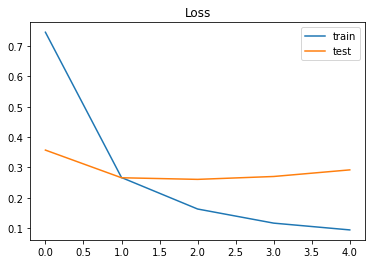

In [70]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
def GetCategory(pred,LABELS):
    returnVal=[]
    curr_index=0
    curr_val=0
    for item in pred:
        val=max(item)
        index=list(item).index(val)
        #print(val,LABELS[index])
        if val>curr_val:
            curr_index=index
            curr_val=val
            
    return LABELS[curr_index]
    #returnVal.append(LABELS[np.argmax(np.array(item))])
    #return returnVal
        
for key,item in df.iterrows():
    data=[]
    data.append(item['cleaned_hm'])
    sentences = filter_stop_words(data, stop_words)
    #seq = tokenizer.texts_to_sequences(data)
    seq = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    print(pred)
    category=LABELS[np.argmax(pred)]
    #category=GetCategory(pred,LABELS)
    print(data, "[predicted category]", category, "[actual category]",item['predicted_category'])
    #break
    #print(pred, LABELS[np.argmax(pred)])

[[9.8373489e-03 9.8652190e-01 2.9949029e-03 3.2388722e-04 1.1194353e-04
  5.4033018e-05 1.5605670e-04]]
['I went successful date someone I felt sympathy connection with.'] [predicted category] affection [actual category] affection
[[9.7042117e-05 9.9988222e-01 2.6239854e-06 1.1754068e-05 2.4080134e-07
  1.3799292e-06 4.6421410e-06]]
['I happy son got 90% marks examination'] [predicted category] affection [actual category] affection
[[4.17318063e-07 1.06075404e-07 2.94004949e-05 1.46564041e-08
  9.99949217e-01 5.27500015e-06 1.56395217e-05]]
['I went gym morning yoga.'] [predicted category] exercise [actual category] exercise
[[2.6848320e-05 9.9995935e-01 3.2823659e-06 3.6291060e-06 2.4512462e-07
  2.8665092e-06 3.8111532e-06]]
['I went grandchildren butterfly display Crohn Conservatory'] [predicted category] affection [actual category] affection
[[0.0309596  0.09067698 0.00317184 0.02923984 0.02104362 0.7593749
  0.06553323]]
['I meditated last night.'] [predicted category] leisure [ac

[[9.9999642e-01 8.2311749e-07 1.0386877e-06 1.2868304e-06 8.8861512e-08
  2.8033301e-07 3.3555608e-08]]
['I got promotion today 2 years service job.'] [predicted category] achievement [actual category] achievement
[[9.9883920e-01 4.6467299e-05 8.5618834e-05 8.1623771e-04 5.3329211e-05
  1.3629980e-04 2.2838667e-05]]
['I woke early morning 7 daily 8:30'] [predicted category] achievement [actual category] achievement
[[9.8999351e-01 9.6675595e-03 2.4576805e-04 2.9865872e-05 2.3408284e-05
  1.9185274e-05 2.0792335e-05]]
['I slow cooked chuck roast stove came great.'] [predicted category] achievement [actual category] achievement
[[1.1959690e-06 2.2718655e-06 9.9998188e-01 6.2083404e-07 1.3585212e-05
  4.9699230e-07 5.5848375e-08]]
['I saw two close friends I seen couple months.'] [predicted category] bonding [actual category] bonding
[[4.8675490e-04 9.9941421e-01 1.8645916e-05 6.8623711e-05 6.1855673e-07
  4.3757354e-06 6.6500988e-06]]
['I cooked girlfriend wonderful breakfast.'] [predict

[[2.1953594e-02 7.5629709e-05 1.5527387e-04 9.7585255e-01 2.2114615e-05
  1.8484460e-03 9.2404538e-05]]
['I able sleep longer usual'] [predicted category] enjoy_the_moment [actual category] achievement
[[8.7876821e-01 1.2096887e-01 9.2919232e-05 8.7603112e-05 1.2607926e-05
  3.7909056e-05 3.1906497e-05]]
['Yesterday solved big issue related family'] [predicted category] achievement [actual category] achievement
[[1.7812303e-06 1.2176203e-05 9.9994528e-01 2.6293362e-06 3.5986872e-05
  1.7890599e-06 3.3880252e-07]]
['In past 24 hours, I talked friend call often.'] [predicted category] bonding [actual category] bonding
[[2.3265373e-05 9.9993646e-01 2.4926299e-05 1.4309548e-05 1.0110678e-07
  4.0599681e-07 6.2883100e-07]]
['I long talk son lives far away fro me. We always good conversations.'] [predicted category] affection [actual category] affection
[[9.9994922e-01 2.0525167e-05 4.1761650e-06 5.7762913e-06 4.1071949e-06
  1.4131462e-05 2.1026769e-06]]
['I finally mastered make crispy tof

  6.1639832e-07 1.6559281e-07]]
['I met childhood friend 10 years'] [predicted category] bonding [actual category] bonding
[[2.6163941e-03 3.1346354e-01 1.1461462e-03 6.8149143e-01 5.5449227e-06
  5.7105318e-04 7.0598355e-04]]
['GO TO HOTEL PARTY OF MY MOMS BIRTHDAY'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[3.2467909e-05 9.9993908e-01 7.1142645e-06 1.3161854e-05 3.4353175e-07
  9.9190083e-07 6.9122234e-06]]
['My children kissing goodnight.'] [predicted category] affection [actual category] affection
[[2.26802167e-05 9.99845386e-01 1.51950799e-05 1.11217676e-04
  1.50269912e-07 3.13382861e-06 2.41245152e-06]]
['My girlfriend surprised favorite dinner (tacos).'] [predicted category] affection [actual category] affection
[[5.5474693e-01 6.8285160e-02 3.3923709e-03 3.4468910e-01 3.3871937e-04
  2.5844915e-02 2.7027542e-03]]
['I get come home earlier boss vacation.'] [predicted category] achievement [actual category] enjoy_the_moment
[[8.9992664e-06 9.9991

[[9.9994028e-01 2.0401842e-05 1.9999106e-05 9.0090016e-06 2.2352049e-06
  6.6527045e-06 1.2863985e-06]]
['I received enough funding start research project abroad summer.'] [predicted category] achievement [actual category] achievement
[[5.1203609e-04 1.8619972e-05 3.8670900e-04 4.4286835e-06 9.9848253e-01
  8.6191045e-05 5.0953764e-04]]
['I finally went run worked felt great taking care body.'] [predicted category] exercise [actual category] exercise
[[1.3535193e-05 9.9989808e-01 8.1924947e-05 4.8898423e-06 2.7445006e-07
  5.0401928e-07 8.5938035e-07]]
['Had nice conversation wife neighbour rarely speaks me. She seems nice.'] [predicted category] affection [actual category] affection
[[2.5107808e-04 1.4420090e-05 9.9951625e-01 2.2891034e-05 1.7123572e-04
  2.3079901e-05 1.0319633e-06]]
['I spoke college friend Angie 30 minutes first time since last summer.'] [predicted category] bonding [actual category] bonding
[[1.3961509e-03 8.6406531e-04 6.2164664e-04 9.5378077e-03 4.4689182e-04
  

[[9.9991739e-01 5.6676865e-05 1.8608216e-05 3.4253615e-06 1.4420602e-06
  1.8339396e-06 7.5891870e-07]]
['I got computer fixed finally.Now get back things need get done.'] [predicted category] achievement [actual category] achievement
[[0.3009543  0.01714117 0.2595413  0.07967491 0.00974261 0.331917
  0.00102871]]
['Participated ugadi food festival office'] [predicted category] leisure [actual category] achievement
[[9.9996066e-01 3.2064429e-05 2.3711211e-06 5.8652654e-07 1.2114972e-06
  2.4010076e-06 6.5986973e-07]]
['I done job planned. I pleased.'] [predicted category] achievement [actual category] achievement
[[9.9935430e-01 2.6321955e-05 9.9357021e-06 6.3141551e-06 2.3674098e-05
  5.7405297e-04 5.4016741e-06]]
['Got new iPhone 7 Plus (Product Red)'] [predicted category] achievement [actual category] achievement
[[9.9998331e-01 1.0980813e-06 1.8756713e-06 5.9459335e-06 8.3749001e-07
  6.6303032e-06 2.4196569e-07]]
['I basketball medal team I leader mvp match'] [predicted category] 

[[1.4891290e-05 9.9996817e-01 4.5474467e-06 1.0498997e-05 6.6150129e-08
  3.0588791e-07 1.4834714e-06]]
['I shared big breakfast boyfriend'] [predicted category] affection [actual category] affection
[[9.9950743e-01 1.5604812e-04 2.3789287e-05 1.3190667e-04 1.3367917e-05
  1.5804786e-04 9.4133648e-06]]
["got bonuses work i'm getting regularly"] [predicted category] achievement [actual category] achievement
[[1.3385363e-05 3.5574524e-06 9.9994659e-01 5.1275802e-06 2.8086601e-05
  3.0699580e-06 1.3161200e-07]]
['I got email old friend.'] [predicted category] bonding [actual category] bonding
[[8.7851495e-06 9.9998152e-01 3.9730394e-06 3.6559209e-06 8.6567127e-08
  5.4631607e-07 1.3456026e-06]]
['My mother recovering weakness chemotherapy cycle.'] [predicted category] affection [actual category] affection
[[1.5303136e-03 9.9522972e-01 2.1042165e-03 6.8131332e-05 3.7155178e-04
  3.2733934e-04 3.6869495e-04]]
['I brought gifts siblings.'] [predicted category] affection [actual category] aff

[[3.0766878e-05 2.1429300e-04 9.8417217e-01 1.5273801e-02 1.4825746e-04
  1.3621786e-04 2.4412271e-05]]
['A good dinner nice restaurant coworkers.'] [predicted category] bonding [actual category] bonding
[[2.0130748e-01 7.9309022e-01 3.7328369e-04 1.0933330e-03 1.7781640e-04
  2.3111262e-04 3.7267618e-03]]
['I take kids school today first day spring break.'] [predicted category] affection [actual category] affection
[[3.0596689e-07 2.2225274e-06 9.9998593e-01 3.5278657e-07 1.0653268e-05
  6.1566749e-07 4.7035698e-08]]
['I lunch friend I seen awhile.'] [predicted category] bonding [actual category] bonding
[[5.4062134e-06 9.9638969e-01 2.0455262e-05 5.0331630e-05 1.2830391e-06
  3.5150012e-03 1.7655246e-05]]
['I watched favorite movie wife late night'] [predicted category] affection [actual category] affection
[[9.9999166e-01 4.5373949e-06 1.0431669e-06 8.5262275e-07 6.2641516e-07
  9.0974657e-07 4.0429748e-07]]
['I finally got job interview.'] [predicted category] achievement [actual c

[[0.08151974 0.00294534 0.00103359 0.00251611 0.00175592 0.9092639
  0.00096534]]
['I spent time kitchen making chicken soup.'] [predicted category] leisure [actual category] leisure
[[9.2345113e-01 3.1052949e-03 4.5973025e-04 3.0775330e-04 8.4584765e-04
  7.1617514e-02 2.1272323e-04]]
['I cooked tasty dinner leftovers.'] [predicted category] achievement [actual category] achievement
[[1.8600051e-05 9.9994862e-01 1.8118119e-05 1.2610366e-05 1.4721023e-07
  4.0550142e-07 1.5392251e-06]]
['I called sister wish happy birthday, nice telephone chat.'] [predicted category] affection [actual category] affection
[[8.7544584e-04 1.0037079e-03 5.7207115e-05 7.0989033e-04 1.3898487e-03
  2.5393823e-04 9.9571002e-01]]
["The weather starting warm I'm super happy about."] [predicted category] nature [actual category] nature
[[9.8820847e-06 9.9997032e-01 1.7945181e-06 1.2442593e-05 7.2834865e-08
  1.9366671e-06 3.6073620e-06]]
['enjoyed week end family'] [predicted category] affection [actual categor

[[2.2934571e-06 9.9999094e-01 2.0487876e-06 2.4756666e-06 4.1804313e-08
  9.3005605e-07 1.3412056e-06]]
['Snuggling dog give stinky breath kisses'] [predicted category] affection [actual category] affection
[[1.9500078e-01 8.2028366e-04 2.8169705e-03 7.7976054e-01 1.0236722e-03
  1.9932268e-02 6.4541603e-04]]
['I found ordered book online I like lot.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[0.00145902 0.04035839 0.9072665  0.0137893  0.01931069 0.0128052
  0.00501088]]
['Went walk great talk random stranger morning.'] [predicted category] bonding [actual category] bonding
[[9.9936646e-01 1.5746533e-04 1.8512025e-04 1.7932207e-04 2.9061926e-05
  7.6014876e-05 6.5568142e-06]]
['One students told pretty I was.'] [predicted category] achievement [actual category] achievement
[[3.0329093e-07 4.6480886e-06 9.9996388e-01 2.6072928e-05 4.2906081e-06
  5.6356367e-07 1.6967742e-07]]
['I received birthday gift mail good friend mine.'] [predicted category] bondi

[[9.8998427e-01 8.5794996e-04 4.7333864e-04 7.9192165e-03 8.7808417e-05
  5.7331688e-04 1.0406853e-04]]
['My ordered dress fitted nicely.'] [predicted category] achievement [actual category] achievement
[[3.2523767e-05 7.7490231e-06 6.3406692e-06 8.2035267e-06 9.8723522e-06
  9.9993384e-01 1.3816914e-06]]
['I day work I able binge watch TV show interruptions.'] [predicted category] leisure [actual category] leisure
[[1.2995614e-04 9.8796999e-01 2.9443733e-03 2.1318924e-03 2.1370189e-04
  2.9551701e-03 3.6550933e-03]]
['I saw baby ultrasound monitor.'] [predicted category] affection [actual category] affection
[[0.01126854 0.06056018 0.00118839 0.05745173 0.00646788 0.04364781
  0.8194155 ]]
['I visited new park area enjoyed nice walk.'] [predicted category] nature [actual category] nature
[[2.2396166e-04 9.9950409e-01 8.6793283e-05 1.3355952e-04 2.3489720e-06
  1.2676909e-05 3.6619324e-05]]
['Getting see relative lives another state.'] [predicted category] affection [actual category] a

['My girlfriend came cuddled fell asleep.'] [predicted category] affection [actual category] affection
[[1.4182228e-05 9.8208769e-04 8.9396781e-04 2.7872009e-02 3.7683905e-05
  9.7017461e-01 2.5451391e-05]]
['I found good amount things watch Twitch enjoyed quite lot'] [predicted category] leisure [actual category] leisure
[[1.2744781e-01 5.1269692e-04 2.8539705e-04 1.9132915e-04 1.1374940e-03
  8.7035221e-01 7.3083909e-05]]
['I able make time playing video game I gotten around while.'] [predicted category] leisure [actual category] leisure
[[2.9614707e-03 2.6951835e-04 9.8990881e-01 5.3531621e-03 1.0875795e-03
  3.7206765e-04 4.7413429e-05]]
['I received free sushi coworker'] [predicted category] bonding [actual category] bonding
[[2.0676958e-03 1.3692088e-03 1.3172142e-04 5.5738149e-04 2.3380199e-03
  9.9066049e-01 2.8755532e-03]]
['I went watch soccer match stadium. Had fun cheering team'] [predicted category] leisure [actual category] leisure
[[4.3351565e-06 1.9900493e-05 6.0427233e

  1.6227987e-05 1.9981021e-06]]
['I managed make $80 writing.'] [predicted category] achievement [actual category] achievement
[[1.7808795e-06 8.2296523e-05 9.9989140e-01 1.2232576e-05 1.0299006e-05
  1.4102865e-06 6.5234838e-07]]
['Yesterday donuts work celebrate co-workers birthday. It nice surprise!'] [predicted category] bonding [actual category] bonding
[[9.74339962e-01 1.05844716e-04 2.48266812e-02 2.29079858e-04
  4.38390649e-04 4.43905665e-05 1.58022722e-05]]
["Some colleagues I finished project we've working on."] [predicted category] achievement [actual category] achievement
[[0.00693422 0.01190549 0.00101855 0.0893908  0.01653358 0.01398982
  0.8602276 ]]
['I went short day hike wilderness park.'] [predicted category] nature [actual category] nature
[[9.7141731e-01 1.9294080e-04 4.7568046e-04 6.3286963e-05 2.5636863e-02
  2.0217691e-03 1.9217156e-04]]
['I gym hit new record different lifts.'] [predicted category] achievement [actual category] achievement
[[3.6304792e-07 4.59

[[9.5925266e-01 5.4555852e-04 2.1684989e-03 5.7045231e-04 7.7427359e-04
  3.6624227e-02 6.4251610e-05]]
["My boss rewarded tickets pro hockey game that's played later week."] [predicted category] achievement [actual category] achievement
[[9.9433295e-05 9.9967861e-01 5.5315952e-05 1.2739126e-04 5.7533964e-07
  3.3407461e-05 5.3141734e-06]]
["I helped plan surprise party Mom's 70th birthday party coming up."] [predicted category] affection [actual category] affection
[[0.01824971 0.01796581 0.00214044 0.00268443 0.02645608 0.92315865
  0.00934486]]
['When went bathroom'] [predicted category] leisure [actual category] leisure
[[6.9149132e-07 9.9977165e-01 1.0969504e-05 2.1034008e-04 3.5762717e-08
  2.9499281e-06 3.3790916e-06]]
['I ate delicious dinner husband.'] [predicted category] affection [actual category] affection
[[9.9998999e-01 1.5358693e-06 7.6473026e-07 3.6988918e-06 3.8458958e-07
  3.4526061e-06 2.2423565e-07]]
['I 5 dollars lottery scratch off.'] [predicted category] achieve

[[9.6925461e-01 1.7435221e-03 4.1109486e-04 2.5450194e-04 2.6517902e-03
  2.5026230e-02 6.5810193e-04]]
['I booked flight Colombia.'] [predicted category] achievement [actual category] achievement
[[1.5073088e-05 9.9997568e-01 2.1032863e-06 5.7106604e-06 4.2605418e-08
  6.0580999e-07 8.1457921e-07]]
['I gave daughter present witnessed joy.'] [predicted category] affection [actual category] affection
[[6.5241760e-04 3.3591878e-05 1.6101582e-03 3.8952174e-05 9.9682295e-01
  1.0494995e-04 7.3696760e-04]]
['I ran mile 6 minutes today made feel fast.'] [predicted category] exercise [actual category] exercise
[[5.7695994e-05 6.0673610e-06 2.9999703e-05 9.9985099e-01 2.2811862e-07
  5.2674823e-05 2.2953873e-06]]
['I given $10 stranger line coffee today.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[1.5585858e-06 9.9998009e-01 1.4241935e-05 4.2507332e-07 3.2103603e-07
  8.0784912e-07 2.4590909e-06]]
['I talked boyfriend.'] [predicted category] affection [actual c

[[1.2353078e-02 3.4511432e-02 2.1427081e-03 7.0591295e-01 3.8479781e-04
  2.3715515e-01 7.5398297e-03]]
["Going dunkin' donuts getting free dozen made happy today."] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[5.4389206e-03 3.9301557e-03 7.2917072e-03 9.7327322e-01 1.6578654e-04
  9.3575735e-03 5.4247346e-04]]
['I delicious lunch today.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[9.9982989e-01 6.3620901e-05 3.0684084e-06 9.8273900e-05 2.6958520e-07
  4.1386656e-06 6.3555893e-07]]
['In last 24 hours receiving raise work made happy'] [predicted category] achievement [actual category] achievement
[[1.9274395e-03 9.8198032e-01 2.1381676e-04 2.9135094e-04 7.9452002e-05
  1.5319514e-02 1.8801741e-04]]
['Watching son play guitar church band.'] [predicted category] affection [actual category] affection
[[9.9999368e-01 2.0465789e-06 8.7010204e-07 4.1830569e-07 4.9442264e-07
  2.3789548e-06 1.3102670e-07]]
['I got burger lunch cooke

[[1.6625428e-03 9.7182792e-01 2.1847409e-04 2.9630342e-03 2.2573488e-04
  5.1612821e-03 1.7940974e-02]]
['I took dogs walk nice day'] [predicted category] affection [actual category] affection
[[6.6023604e-05 9.9989092e-01 5.7261050e-06 1.8016110e-05 7.3199141e-07
  9.5494133e-06 9.1020038e-06]]
['Seeing girlfriend bed wake'] [predicted category] affection [actual category] affection
[[3.7499638e-05 9.9896586e-01 1.3404986e-05 9.5773255e-04 4.0945147e-07
  8.2939241e-06 1.6808954e-05]]
['I cooked ate satisfying meal wife I.'] [predicted category] affection [actual category] affection
[[6.1599526e-06 9.9755472e-01 2.3944783e-03 1.8891675e-05 5.9143777e-06
  7.0932606e-06 1.2571900e-05]]
['I witnessed daughter playing outside friends right outside window.'] [predicted category] affection [actual category] affection
[[9.9967515e-01 1.7136113e-04 3.1206509e-06 1.4127691e-04 5.7991866e-07
  1.7740468e-06 6.6170051e-06]]
['I happy I upgraded first class flight home.'] [predicted category] ac

[[7.2186114e-04 4.8184674e-03 3.7282391e-04 6.8021305e-03 5.3791550e-04
  9.8580903e-01 9.3774463e-04]]
['I reading hammock.'] [predicted category] leisure [actual category] leisure
[[9.9867225e-01 2.5988059e-04 1.9288711e-05 7.3031391e-05 2.4195586e-05
  9.1878138e-04 3.2564527e-05]]
['I finished classes become lasted foster parent last night. It last'] [predicted category] achievement [actual category] achievement
[[1.34054435e-05 9.99954104e-01 3.93034543e-06 2.08198417e-05
  9.23428303e-08 5.99096393e-06 1.67852977e-06]]
['My girlfriend cuddled went sleep long time last night'] [predicted category] affection [actual category] affection
[[9.9839032e-01 1.1572851e-04 8.6338725e-04 4.4138110e-04 2.3539202e-05
  1.5911167e-04 6.5373792e-06]]
['I got new credit card mail today excited that.'] [predicted category] achievement [actual category] achievement
[[0.04274493 0.0125205  0.00248779 0.03837537 0.0038959  0.8954394
  0.00453615]]
['Getting back massage'] [predicted category] leisur

[[2.5688232e-05 9.9996901e-01 2.3697664e-06 1.5669071e-06 9.8196637e-08
  1.5692481e-07 1.1367065e-06]]
['My boyfriend told proud me.'] [predicted category] affection [actual category] affection
[[0.0394596  0.02142275 0.01692285 0.06693237 0.15042305 0.6518251
  0.05301427]]
['I meditated morning.'] [predicted category] leisure [actual category] leisure
[[9.9998546e-01 1.0300986e-05 1.6386069e-06 1.7619045e-06 1.8560829e-07
  5.1018407e-07 1.2167764e-07]]
['Visit dentist went well. Dentist said I cavities oral issues.'] [predicted category] achievement [actual category] achievement
[[9.99761760e-01 6.45302644e-05 2.87839903e-05 1.30954604e-05
  1.57391041e-05 1.10975714e-04 5.07942150e-06]]
['I completed upgrading switches house everything looks much better.'] [predicted category] achievement [actual category] achievement
[[1.0593520e-03 6.1000662e-04 1.7587266e-04 9.8731309e-01 4.3632681e-06
  1.0797313e-02 4.0026523e-05]]
['Cooked ate delicious steak.'] [predicted category] enjoy_th

[[4.8269115e-02 1.7148657e-03 4.4058787e-04 6.7087314e-03 4.9501774e-04
  9.4194925e-01 4.2239073e-04]]
['I brought card game try playing client enjoyed it.'] [predicted category] leisure [actual category] leisure
[[9.9977189e-01 6.9634887e-05 8.9347159e-05 1.8786948e-05 1.5501428e-05
  3.1336538e-05 3.4045038e-06]]
['I finally got hang knitting, completed entire half vest'] [predicted category] achievement [actual category] achievement
[[6.1835919e-05 7.6173753e-01 1.9400301e-05 3.7243979e-05 3.4898653e-04
  6.5598649e-04 2.3713902e-01]]
['I went outside play daughters weather beautiful blast.'] [predicted category] affection [actual category] affection
[[1.5959276e-03 4.9470118e-03 1.9008212e-04 9.8513687e-01 1.5160588e-05
  6.5035340e-03 1.6113372e-03]]
['I great night sleep sleeping well lately.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[0.13611332 0.48651525 0.00394454 0.2767358  0.00090857 0.08532628
  0.01045618]]
['Sleeping little warm bed morn

[[2.3871462e-04 7.1838200e-05 3.2339941e-04 1.3598629e-06 9.9864346e-01
  7.2686737e-05 6.4849580e-04]]
['I went gym first time 6 months.'] [predicted category] exercise [actual category] exercise
[[3.9783958e-05 3.0245021e-04 1.2772707e-05 9.9960524e-01 1.2572069e-07
  2.9153794e-05 1.0480563e-05]]
['I ate juicy piece pizza. I pizza long time. This made happy.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[3.1019941e-02 3.5928449e-04 5.5139226e-01 4.1624230e-01 1.8098499e-04
  7.7990216e-04 2.5285968e-05]]
['My annoying co-workers away conference office really peaceful.'] [predicted category] bonding [actual category] enjoy_the_moment
[[1.5722277e-06 1.8148899e-05 9.9979788e-01 4.0496675e-06 1.0741251e-04
  7.0105067e-05 9.7351199e-07]]
['I took walk lunch friend played pokemon go'] [predicted category] bonding [actual category] bonding
[[9.9360732e-06 3.9680722e-06 7.9438269e-06 3.1257656e-05 4.2221186e-06
  9.9994183e-01 8.2519460e-07]]
['I Had fun play

['I called friend I owe money said okay I repaid later date.'] [predicted category] bonding [actual category] bonding
[[9.9996769e-01 8.0278305e-06 5.4941183e-06 1.4637043e-05 1.0600643e-06
  2.7905755e-06 3.7407310e-07]]
['I checked lotto ticket today found I $2.00.'] [predicted category] achievement [actual category] achievement
[[4.6930785e-04 7.9402875e-05 3.5907320e-05 9.3279535e-01 8.5506144e-07
  6.6584930e-02 3.4234487e-05]]
['I got sleep since I work enjoy day myself.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[1.3429800e-05 9.9957126e-01 1.9590829e-05 3.5132916e-04 3.3272755e-07
  2.3773184e-05 2.0198835e-05]]
['I made watermelon-flavored jello reminded love watermelon Jolly Ranchers.'] [predicted category] affection [actual category] affection
[[9.9403691e-01 9.2463932e-05 1.2159325e-04 5.7331240e-03 1.8891317e-06
  1.0815949e-05 3.3167848e-06]]
['I received media credentials important event mail'] [predicted category] achievement [actual cat

[[9.9857092e-01 4.3538338e-04 1.8162178e-04 4.2816109e-04 1.0183299e-04
  7.6184115e-05 2.0598667e-04]]
['Easy commute work'] [predicted category] achievement [actual category] achievement
[[2.2418721e-05 4.2641350e-05 4.3772081e-05 3.3313338e-02 1.9012707e-06
  9.6654797e-01 2.8013168e-05]]
['Watching movie eating leftover chinese food. It complete bliss.'] [predicted category] leisure [actual category] leisure
[[2.3137496e-03 9.9744356e-01 5.8516347e-05 1.7394511e-04 8.7453998e-07
  3.8054895e-06 5.5557580e-06]]
["I talked Mom received good doctor's report blood work."] [predicted category] affection [actual category] affection
[[1.1162689e-05 9.9972862e-01 2.8678398e-05 2.0326907e-04 2.3164107e-07
  2.2158751e-05 5.6998106e-06]]
['I played hide seek cat, favorite interactive game. He makes laugh.'] [predicted category] affection [actual category] affection
[[9.4768047e-01 8.8425812e-05 2.5540450e-05 2.5548345e-05 1.1120165e-04
  5.2041493e-02 2.7391969e-05]]
['I got play new compute

[[1.5386458e-05 4.5755081e-05 3.4636157e-06 8.5471482e-05 1.2244514e-05
  9.9982917e-01 8.4307376e-06]]
['I saw new episode Mindy Project I excited watch it.'] [predicted category] leisure [actual category] leisure
[[4.2929321e-05 6.7666704e-05 6.5138843e-04 2.2453168e-02 7.0406262e-05
  9.7668922e-01 2.5323543e-05]]
['I got favorite ice cream ice cream parlor'] [predicted category] leisure [actual category] leisure
[[9.9174213e-01 1.8201585e-04 4.0167259e-04 4.7648288e-03 2.7129336e-04
  2.5945236e-03 4.3431904e-05]]
['I received new video game mail I waiting months receive.'] [predicted category] achievement [actual category] achievement
[[1.6780246e-05 9.9965644e-01 2.6798498e-05 4.6844998e-05 1.3385263e-06
  2.2290983e-04 2.8783952e-05]]
['Having time kids.'] [predicted category] affection [actual category] affection
[[5.2742757e-06 8.5269472e-05 2.3183586e-05 1.3228791e-04 3.1945158e-06
  9.9974507e-01 5.7429661e-06]]
['I watched favorite eSports team dismantle enemy ease.'] [pred

[[0.00225658 0.45351917 0.0005458  0.07396859 0.00397879 0.07407036
  0.39166084]]
['I went walk park made feel happy.'] [predicted category] affection [actual category] nature
[[6.8313363e-07 6.4269429e-06 9.9995589e-01 1.4144736e-06 3.3341159e-05
  2.0396974e-06 1.6184489e-07]]
['I went dinner friends, meeting.'] [predicted category] bonding [actual category] bonding
[[1.7645107e-06 7.5722323e-06 9.9974984e-01 6.1108051e-07 2.3659077e-04
  3.3300716e-06 3.5114201e-07]]
['I went gym friend mine I seen long time.'] [predicted category] bonding [actual category] bonding
[[9.9915493e-01 3.8593140e-04 4.3654214e-05 9.9593839e-05 6.0981252e-05
  2.2207695e-04 3.2819673e-05]]
['I finally felt like I recovered illness I suffering last week.'] [predicted category] achievement [actual category] achievement
[[9.9997294e-01 5.3065701e-06 5.7461048e-06 1.4204558e-05 2.6265758e-07
  1.1604014e-06 3.0774038e-07]]
['Being able make nice amount money amazon today.'] [predicted category] achievement [

[[4.0620875e-05 6.5348810e-05 6.9444533e-05 9.9883384e-01 3.7887017e-07
  9.8582008e-04 4.6787950e-06]]
["I ate McDonald's breakfast."] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[2.9788751e-05 2.4064098e-04 4.4348785e-06 3.9142687e-05 2.8832915e-04
  4.5661167e-05 9.9935204e-01]]
['The weather really nice yesterday enjoyable outside.'] [predicted category] nature [actual category] nature
[[3.7410203e-07 2.8164861e-06 1.4661164e-06 1.3967826e-04 1.7312685e-07
  9.9985528e-01 2.9223781e-07]]
['I watched couple episodes one favorite comedy shows.'] [predicted category] leisure [actual category] leisure
[[9.4799771e-06 9.9949217e-01 1.4327313e-05 2.1922043e-04 2.9516075e-06
  1.1079090e-04 1.5099034e-04]]
['I took dog walk, happy.'] [predicted category] affection [actual category] affection
[[9.9930263e-01 3.6959140e-05 8.5463056e-05 4.2039540e-04 1.3937244e-05
  1.3643548e-04 4.3139762e-06]]
['These lemon donuts I bought Publix.'] [predicted category] achie

[[7.0360411e-06 9.9997604e-01 1.2666710e-05 3.0705341e-06 6.4170464e-08
  6.2414119e-07 4.5962426e-07]]
['My boyfriend came home work early got spend time together.'] [predicted category] affection [actual category] affection
[[1.3756821e-06 9.9986660e-01 4.6393885e-05 6.7839261e-05 1.2910149e-07
  1.4999992e-05 2.6037208e-06]]
['I went lunch boyfriend sat outside ate enjoyed food together.'] [predicted category] affection [actual category] affection
[[1.8357078e-06 1.0307071e-05 1.1701566e-06 1.4483065e-05 2.0880539e-06
  9.9996936e-01 6.5837634e-07]]
['I linked hilarious video: https://www.youtube.com/watch?v=ptKgRecPi1I'] [predicted category] leisure [actual category] leisure
[[2.6090082e-05 9.9990058e-01 2.7240978e-05 3.3474589e-05 7.5361288e-07
  4.8393754e-06 6.8717331e-06]]
["I looked pictures unborn baby's ultrasound."] [predicted category] affection [actual category] affection
[[9.9999654e-01 1.3680078e-06 6.9869145e-07 8.1310526e-07 1.4320331e-07
  3.0754725e-07 8.0181294e-08

[[9.9997771e-01 7.6119240e-06 3.2671358e-06 8.9020077e-06 4.3350903e-07
  1.7258532e-06 3.9493057e-07]]
['I completely conquered laundry. There dirty clothes house.'] [predicted category] achievement [actual category] achievement
[[9.9963343e-01 8.9524292e-05 4.4469518e-05 3.9762061e-05 4.4326614e-05
  1.3110391e-04 1.7352428e-05]]
['I got paycheck.'] [predicted category] achievement [actual category] achievement
[[6.8223721e-01 2.2454336e-03 6.9385604e-03 2.9882357e-01 2.9175958e-04
  9.3407901e-03 1.2266188e-04]]
["Deciding I'm going attend meet-up podcasts I routinely listen to."] [predicted category] achievement [actual category] enjoy_the_moment
[[6.5150084e-03 4.2276841e-04 2.4490219e-03 2.8037659e-05 9.8131150e-01
  5.5062282e-03 3.7675493e-03]]
['I went run around block.'] [predicted category] exercise [actual category] exercise
[[9.9997854e-01 4.9833830e-06 3.7464997e-06 3.7557868e-06 2.0961834e-06
  5.5307878e-06 1.2998332e-06]]
['I finished errands I working day.'] [predicte

[[1.6279973e-05 5.2378355e-06 9.9973387e-01 1.0040108e-05 1.7911311e-04
  5.5095035e-05 3.8748897e-07]]
['I booked trip go New York two close friends.'] [predicted category] bonding [actual category] bonding
[[9.9886876e-01 4.7195345e-04 3.8615734e-05 6.3026579e-05 1.6934633e-05
  5.3059380e-04 1.0127486e-05]]
['I chain-smoker last 24 hours take single one.'] [predicted category] achievement [actual category] achievement
[[1.0317023e-05 9.9961662e-01 2.8995717e-05 5.7605172e-07 4.9144833e-06
  3.1437670e-04 2.4191528e-05]]
['playing game Magic daughter'] [predicted category] affection [actual category] affection
[[2.0093286e-02 9.9575846e-04 3.8823622e-04 9.6905351e-01 2.5092988e-04
  6.1521195e-03 3.0661782e-03]]
['Getting weed dealer I out!'] [predicted category] enjoy_the_moment [actual category] achievement
[[8.2244522e-05 1.7501345e-04 3.5870945e-04 1.3582155e-02 6.7719826e-05
  9.8568428e-01 4.9843453e-05]]
['I got favorite ice cream cone.'] [predicted category] leisure [actual c

[[9.9949276e-01 3.7884997e-04 4.0374103e-05 2.7896853e-05 1.2623383e-05
  3.7582304e-05 9.8322162e-06]]
['buy new shoes today.'] [predicted category] achievement [actual category] achievement
[[1.4247862e-01 8.5532677e-01 3.1070117e-04 1.6378353e-03 1.7397644e-05
  1.1218744e-04 1.1648250e-04]]
["Found dad's flight safely landed Boston entered hotel."] [predicted category] affection [actual category] affection
[[1.2763285e-03 9.4096019e-04 3.7851632e-03 9.8847419e-01 7.9558187e-05
  5.0517623e-03 3.9212790e-04]]
['drank great coffee today'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[6.7917485e-04 9.9931121e-01 3.5104031e-06 2.4795320e-06 2.8576156e-07
  6.2049935e-07 2.8525717e-06]]
['My husband surprised finishing laundry.'] [predicted category] affection [actual category] affection
[[6.4269566e-06 9.9992466e-01 4.0138516e-06 5.2436812e-05 1.8441682e-07
  1.2924284e-06 1.0885898e-05]]
['I enjoyed dinner family backyard.'] [predicted category] affection 

[[1.3994935e-06 3.1820990e-05 1.3361634e-05 4.3033095e-04 8.2388578e-07
  9.9952090e-01 1.4330395e-06]]
['I watched movie really good.'] [predicted category] leisure [actual category] leisure
[[4.3570503e-04 9.9944168e-01 8.6939377e-05 1.6193902e-05 2.2653151e-06
  4.4192952e-06 1.2766148e-05]]
['I came home work two cats waiting door welcome home.'] [predicted category] affection [actual category] affection
[[2.7599772e-03 4.1774969e-05 3.7768786e-03 2.0664573e-05 9.9185610e-01
  7.1799941e-04 8.2667434e-04]]
['I actually time today workout 30 minutes.'] [predicted category] exercise [actual category] exercise
[[1.5316153e-04 1.1238875e-04 1.3980485e-04 1.3464558e-03 1.4412873e-04
  9.9793565e-01 1.6840556e-04]]
['Watching The Atomic Brain.'] [predicted category] leisure [actual category] leisure
[[9.8367667e-01 4.4183202e-05 1.5828651e-04 1.5968362e-02 2.3303372e-05
  1.0991898e-04 1.9271274e-05]]
['I able make coffee sit minutes driving work.'] [predicted category] achievement [actu

[[0.011598   0.01791915 0.00099247 0.0033884  0.00106267 0.96363705
  0.00140231]]
['I given free Flyers tickets I currently game great time.'] [predicted category] leisure [actual category] leisure
[[4.1696524e-07 1.9561247e-05 9.9977380e-01 1.1037679e-06 1.8688673e-04
  1.7744343e-05 4.2969228e-07]]
['playing play station 4 friend'] [predicted category] bonding [actual category] bonding
[[5.9472054e-04 8.2431470e-05 1.7842009e-05 9.9898130e-01 6.4182632e-07
  3.0705560e-04 1.6095762e-05]]
["After long day, I picked six pack beer; I'm process enjoying now."] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[3.5853649e-04 9.9960726e-01 8.7939634e-06 1.6807287e-05 5.6378889e-07
  3.1157615e-06 4.8325464e-06]]
['I got word step sister successful surgery yesterday well.'] [predicted category] affection [actual category] affection
[[9.9992979e-01 3.7693626e-05 6.1808878e-06 3.7681098e-06 2.0520120e-06
  1.9673003e-05 8.1186550e-07]]
['I phone interview job I applie

[[9.9996555e-01 9.6970871e-06 1.3836790e-06 1.9055065e-05 2.6609763e-07
  3.7449154e-06 3.3222736e-07]]
['I got raise performance reviews past month.'] [predicted category] achievement [actual category] achievement
[[9.5582849e-01 1.2080705e-03 3.1820182e-02 2.0728003e-04 1.0565587e-02
  1.9125275e-04 1.7938181e-04]]
['I completed difficult 5K running race age group.'] [predicted category] achievement [actual category] achievement
[[1.6536740e-04 2.4158524e-03 5.2170119e-05 1.1392568e-03 2.0992201e-04
  9.9470150e-01 1.3159387e-03]]
['Buying air flights vacation May.'] [predicted category] leisure [actual category] achievement
[[9.7882254e-03 9.9013406e-01 4.2369375e-05 2.4286430e-05 1.5524537e-06
  2.4688761e-06 6.9059333e-06]]
['An immediate family member received promotion work.'] [predicted category] affection [actual category] affection
[[2.53396691e-04 9.99066293e-01 2.63236696e-04 1.58966504e-04
  3.61765137e-06 2.40716967e-04 1.37831885e-05]]
['I met girl coffee shop got phone 

[[9.9932861e-01 2.7713588e-05 1.0273081e-04 2.7384982e-04 1.2706895e-04
  1.3026693e-04 9.7988896e-06]]
['I lost 5 pounds awesome considering I never ever lose weight.'] [predicted category] achievement [actual category] achievement
[[9.9718493e-01 7.4424752e-05 3.1920794e-05 7.4097916e-05 1.3303914e-05
  2.6109230e-03 1.0330375e-05]]
["My favorite men's college basketball team made final four first time ever."] [predicted category] achievement [actual category] achievement
[[1.7527111e-03 3.0628054e-03 7.2043057e-04 9.6729916e-01 2.4314578e-04
  1.7972948e-03 2.5124442e-02]]
['My hostas emerging! I see tips. Spring near!'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[9.9789977e-01 9.5591426e-04 1.7191867e-04 7.3308358e-04 2.5426827e-05
  1.9505198e-04 1.8808882e-05]]
['Got engaged new life.'] [predicted category] achievement [actual category] achievement
[[2.4913596e-03 1.0072883e-03 6.3317115e-05 9.9508899e-01 2.7221122e-06
  5.0726259e-04 8.3915523e-04]

[[1.3268002e-06 9.9999738e-01 3.7442467e-07 2.1845811e-07 8.1884961e-09
  5.3358360e-07 2.4400808e-07]]
['I finally got go home spend time family.'] [predicted category] affection [actual category] affection
[[9.9942744e-01 1.8282175e-04 4.2762978e-05 2.7718695e-04 8.3764862e-06
  5.2064999e-05 9.4708957e-06]]
['Start construction work new home.'] [predicted category] achievement [actual category] achievement
[[9.9994648e-01 1.3041927e-05 9.5863888e-06 2.6324946e-05 1.0772762e-06
  2.8275085e-06 7.4658828e-07]]
['buying new car'] [predicted category] achievement [actual category] achievement
[[9.9999583e-01 1.0566451e-06 1.2805151e-06 1.1555919e-06 1.7706591e-07
  3.1608550e-07 6.9917583e-08]]
['I felt I done good job project work.'] [predicted category] achievement [actual category] achievement
[[9.9501401e-01 7.3080366e-05 6.9643451e-05 4.7962004e-03 2.7251072e-06
  3.9804712e-05 4.4760236e-06]]
["I saw great horned owl scarf mouse. I've witnessed couple times."] [predicted category]

[[1.6520685e-02 2.4885595e-01 7.7006721e-04 7.3154849e-01 5.1671126e-05
  6.6753710e-04 1.5855449e-03]]
['Moving back home made happy.'] [predicted category] enjoy_the_moment [actual category] enjoy_the_moment
[[1.4335350e-05 4.8623756e-02 9.5115888e-01 5.4342167e-05 1.2471236e-04
  1.5095601e-05 8.8649585e-06]]
['My grandmother came back seeing friend really good mood.'] [predicted category] bonding [actual category] bonding
[[9.9372041e-01 5.5148511e-04 6.4297626e-04 4.7708424e-03 5.4714146e-05
  1.9861455e-04 6.0916329e-05]]
['My favorite team match comprehensively.'] [predicted category] achievement [actual category] achievement
[[9.9178887e-06 9.9997818e-01 2.4144683e-06 6.3950424e-06 8.4455621e-08
  7.8810803e-07 2.0917435e-06]]
['I happy last month wife got delivered cute baby girl looks like'] [predicted category] affection [actual category] affection
[[9.9999452e-01 2.7112167e-06 7.5715252e-07 4.2525301e-07 4.5719855e-07
  8.1510200e-07 2.2841611e-07]]
['When I bought first sm

[[6.2872095e-05 9.9967849e-01 6.9414132e-06 2.4619809e-04 1.0712516e-07
  1.3694261e-06 4.0033569e-06]]
['FAMILY MEMBERS ARE GO TO Year cude AND ENJOY THE FAMILY MEMBERS IS HAPPY OF THE MOMENT'] [predicted category] affection [actual category] affection
[[9.0519410e-07 9.9999321e-01 3.7139157e-06 1.6929438e-06 1.4856660e-08
  2.4271620e-07 1.9404486e-07]]
["Meeting nephew niece brother's home awesome, fun together."] [predicted category] affection [actual category] affection
[[1.1179631e-05 5.0374812e-05 9.9976033e-01 2.8011264e-05 1.4307621e-04
  5.0150738e-06 2.1457543e-06]]
['I hung friends lot.'] [predicted category] bonding [actual category] bonding
[[1.8261278e-06 2.3194293e-04 9.9885464e-01 6.6862945e-06 7.9104793e-04
  1.1011274e-04 3.7740112e-06]]
['I went movies friends.'] [predicted category] bonding [actual category] bonding
[[9.9999583e-01 1.9159172e-06 7.3920722e-07 5.3418563e-07 2.2223301e-07
  7.4647988e-07 7.5422506e-08]]
['I got golden employee award certificate offic